In [1]:
from functools import partial
import torch.nn as nn
from model import get_generator
from supervised_tools.create_train_val_data import create_train_val_dataloaders
import numpy as np
import os
from torch_geometric.data import Data
import torch.nn.functional as F
from rdkit import Chem
# from utils.setup import setup
import torch
print(torch.__version__)
import matplotlib.pyplot as plt
# from torch_lr_finder import LRFinder
from utils.data_utils import mols_from_file, get_atoms_info, rdkit2pyg, pyg2rdkit, save_smiles
# from mappings import *
from train_functions import *

def print_obj_API(obj):
    attributes = [attr for attr in dir(obj) if not attr.startswith('__')]

    # Differentiating between methods and attributes
    methods = [attr for attr in attributes if callable(getattr(obj, attr)) and not attr.startswith('_')]
    attributes = [attr for attr in attributes if not callable(getattr(obj, attr)) and not attr.startswith('_')]
    
    print(f"{type(obj).__name__} Attributes:", attributes)
    print("\n")
    print(f"{type(obj).__name__} Methods:", methods)


#! --- GET DATA ---
guacm_smiles = "/home/nobilm@usi.ch/master_thesis/guacamol/testdata.smiles"
train_guac_mols = mols_from_file(guacm_smiles, True)
train_data = rdkit2pyg(train_guac_mols[:32])


#! --- GET WEIGHTS ---
nweights = {
    'C':    0.03238897867833534,
    'Br':   14.044943820224718,
    'N':    0.21620219229022983,
    'O':    0.2177273617975571,
    'S':    1.6680567139282736,
    'Cl':   2.872737719046251,
    'F':    1.754693805930865,
    'P':    37.735849056603776,
    'I':    100.0,
    'B':    416.6666666666667,
    'Si':   454.54545454545456,
    'Se':   833.3333333333334
}
bweights = { 
    BT.SINGLE:      4.663287337775892, 
    BT.AROMATIC:    4.77780803722868, 
    BT.DOUBLE:      34.74514436607484, 
    BT.TRIPLE:      969.9321047526673 
}

nweights_list = [nweights[k] for k in atom2num]
bweights_list = [bweights[k] for k in bond2num]
bweights_list.insert(0, 1500)
node_weights = torch.tensor(nweights_list) 
edge_weights = torch.tensor(bweights_list) 

#! --- SET UP EXPERIMENT ---
LRrnn, LRout = 1e-5, 1e-5
wd = 5e-4
epoch, max_epoch = 1, 30
bs = 32 # 512

cuda = True if torch.cuda.is_available() else False
device = torch.device("cuda:0" if cuda else "cpu")

train_dataset_loader, val_dataset_loader = create_train_val_dataloaders(train_data, train_data, max_num_node, max_prev_node, bs) #! HERE WORKERS
rnn, output = get_generator()
rnn.apply(weight_init)
output.apply(weight_init)
rnn.ad_hoc_init()
output.ad_hoc_init()

params = list(rnn.parameters()) + list(output.parameters())
optimizer = torch.optim.RMSprop(params, lr=LRrnn)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LRrnn, steps_per_epoch=len(train_dataset_loader), epochs=max_epoch)


2.0.1
2.0.1


[10:52:06] WARNING: no name column found on line 0
[10:52:06] WARNING: no name column found on line 1
[10:52:06] WARNING: no name column found on line 2
[10:52:06] WARNING: no name column found on line 3
[10:52:06] WARNING: no name column found on line 4
[10:52:06] WARNING: no name column found on line 5
[10:52:06] WARNING: no name column found on line 6
[10:52:06] WARNING: no name column found on line 7
[10:52:06] WARNING: no name column found on line 8
[10:52:06] WARNING: no name column found on line 9
[10:52:06] WARNING: no name column found on line 10
[10:52:06] WARNING: no name column found on line 11
[10:52:06] WARNING: no name column found on line 12
[10:52:06] WARNING: no name column found on line 13
[10:52:06] WARNING: no name column found on line 14
[10:52:06] WARNING: no name column found on line 15
[10:52:06] WARNING: no name column found on line 16
[10:52:06] WARNING: no name column found on line 17
[10:52:06] WARNING: no name column found on line 18
[10:52:06] WARNING: no

# MEMORIZATION

In [2]:
# obs = train_guac_mols[5]
# print(Chem.MolToSmiles(obs))
# train_data = rdkit2pyg([obs])

# train_dataset_loader, val_dataset_loader = create_train_val_dataloaders(train_data, train_data, max_num_node, max_prev_node, bs) #! HERE WORKERS
# max_epoch = 2000
# params = list(rnn.parameters()) + list(output.parameters())
# optimizer = torch.optim.RMSprop(params, lr=LRrnn)
# # scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LRrnn, steps_per_epoch=len(train_dataset_loader), epochs=max_epoch)

# def memorize_batch_single_opt(max_epoch, rnn, output, data_loader_, optimizer, node_weights, edge_weights, scheduler=None):
#     rnn.train()
#     output.train()    
#     epoch = 1
#     for _, data in enumerate(data_loader_): data = data
#     while epoch <= max_epoch:
#         rnn.zero_grad()
#         output.zero_grad()
#         loss, edge_loss, node_loss = fit_batch(data, rnn, output, node_weights, edge_weights)
#         loss.backward()
#         optimizer.step()
#         scheduler.step()
#         if epoch % 500 == 0: print(f'Epoch: {epoch}/{max_epoch}, lossEdges {edge_loss:.8f}, lossNodes {node_loss:.8f}')
#         epoch += 1

# memorize_batch_single_opt(max_epoch, rnn, output, train_dataset_loader, optimizer, node_weights, edge_weights, scheduler)
# Ns = [10]
# for i in Ns: generate_mols(i,rnn, output, epoch)

# LSUV

In [3]:
# # A hook executes a f that MUST takes 3 args: a module, an input and an output
# def _lsuv_stats(hook, module, inpt, outpt):
#     ''' For each layer stores mean/std'''
#     acts = to_cpu(outpt)
#     hook.mean = acts.mean()
#     hook.std = acts.std()

# def lsuv_init(activation_module, module_input_to_activation, xb):
#     '''
#     activation_module: module that contains the act func of the layer
#     module_input_to_activation: module that contain the weights used in activation_module
#     xb: batch    
#     '''    
#     h = Hook(activation_module, _lsuv_stats) # registers a forw_hook which executes _lsuv_stats
#     with torch.no_grad():
#         while(model(xb)) is not None and (abs(h.std-1)>1e-3 or abs(h.mean)>1e-3):
#             # modify weights untill activated layer has m=0, std=1
#             module_input_to_activation.bias -= h.mean
#             module_input_to_activation.weight.data /= h.std
#     h.remove()    

# Activations analysis

In [4]:
for idx, (name, module) in enumerate(rnn.named_children()): print(name)

embedding
rnn
output1
output2
node_mlp1
node_mlp2


In [5]:
layer_means_rnn = {}
layer_stds_rnn = {}
layer_hists_rnn = {}
for idx, (name, module) in enumerate(rnn.named_children()):
    if isinstance(module, nn.GRU):
        for ii in range(0,2):
            layer_means_rnn[f'{name}_output_{idx}'] = []
            layer_means_rnn[f'{name}_hidden_{idx}'] = []
            layer_stds_rnn[f'{name}_output_{idx}'] = []
            layer_stds_rnn[f'{name}_hidden_{idx}'] = []
            layer_hists_rnn[f'{name}_output_{idx}'] = []
            layer_hists_rnn[f'{name}_hidden_{idx}'] = []
    else:
        layer_means_rnn[name] = []
        layer_stds_rnn[name] = []
        layer_hists_rnn[name] = []


def append_(idx, name, module, input, output):
    if isinstance(module, nn.GRU):        
        layer_means_rnn[f'{name}_output_{idx}'].append(output[0].data.detach().cpu().numpy().mean())
        layer_stds_rnn[f'{name}_output_{idx}'].append(output[0].data.detach().cpu().numpy().std())
        layer_means_rnn[f'{name}_hidden_{idx}'].append(output[1].data.detach().cpu().numpy().mean())
        layer_stds_rnn[f'{name}_hidden_{idx}'].append(output[1].data.detach().cpu().numpy().std())        
        layer_hists_rnn[f'{name}_output_{idx}'].append(output[0].data.detach().cpu().abs().histc(40,0,10))
        layer_hists_rnn[f'{name}_hidden_{idx}'].append(output[0].data.detach().cpu().abs().histc(40,0,10))        
    else:
        layer_means_rnn[name].append(output.detach().cpu().numpy().mean())
        layer_stds_rnn[name].append(output.detach().cpu().numpy().std())
        layer_hists_rnn[name].append(output.detach().cpu().abs().histc(40,0,10))

In [6]:
for idx, (module_name, module) in enumerate(rnn.named_children()):
    module.register_forward_hook(partial(append_, idx, module_name))

In [7]:
epoch = 0
while epoch < max_epoch:
    loss, loss_edg, loss_nodes = train_rnn_epoch(rnn=rnn, output=output,
                                            data_loader_=train_dataset_loader,
                                            optimizer=optimizer,
                                            node_weights=node_weights, edge_weights=edge_weights,
                                            scheduler = scheduler)
    print(f"Epoch {epoch}, loss_edg: {loss_edg}, loss_nodes: {loss_nodes}")
    epoch +=1

Epoch 0, loss_edg: 0.5496007800102234, loss_nodes: 0.2886897921562195
Epoch 1, loss_edg: 0.5484046936035156, loss_nodes: 0.28839609026908875
Epoch 2, loss_edg: 0.5446205735206604, loss_nodes: 0.28747376799583435
Epoch 3, loss_edg: 0.5332402586936951, loss_nodes: 0.2847287356853485
Epoch 4, loss_edg: 0.508897066116333, loss_nodes: 0.27903711795806885
Epoch 5, loss_edg: 0.4673416018486023, loss_nodes: 0.2699393332004547
Epoch 6, loss_edg: 0.4051443040370941, loss_nodes: 0.25852227210998535
Epoch 7, loss_edg: 0.32087358832359314, loss_nodes: 0.24856790900230408
Epoch 8, loss_edg: 0.22410716116428375, loss_nodes: 0.24343128502368927
Epoch 9, loss_edg: 0.13657096028327942, loss_nodes: 0.24195130169391632
Epoch 10, loss_edg: 0.07490813732147217, loss_nodes: 0.24065572023391724
Epoch 11, loss_edg: 0.0389939546585083, loss_nodes: 0.23771215975284576
Epoch 12, loss_edg: 0.020425710827112198, loss_nodes: 0.23396527767181396
Epoch 13, loss_edg: 0.011262602172791958, loss_nodes: 0.2309060096740722

# WORKING

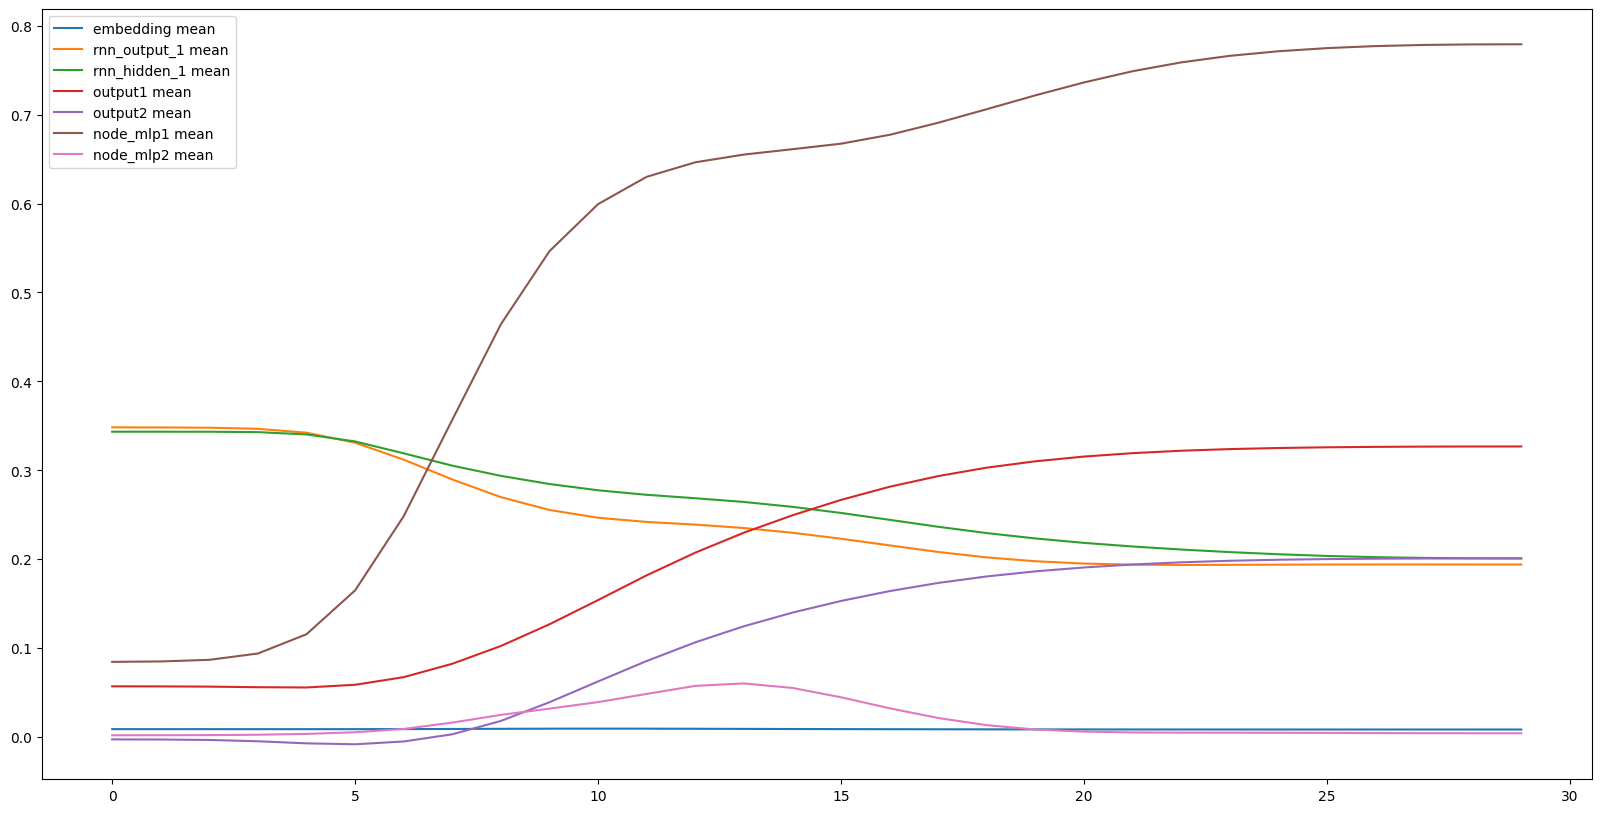

In [8]:
# figsize = 100
# fig = plt.figure(figsize=(10., 10.))
plt.figure(figsize=(20,10))

for color, k in enumerate(layer_means_rnn.keys()):
    plt.plot([i for i in range(len(layer_means_rnn[k]))], layer_means_rnn[k], label=f'{k} mean'.format(i=color))
plt.legend(loc='best')

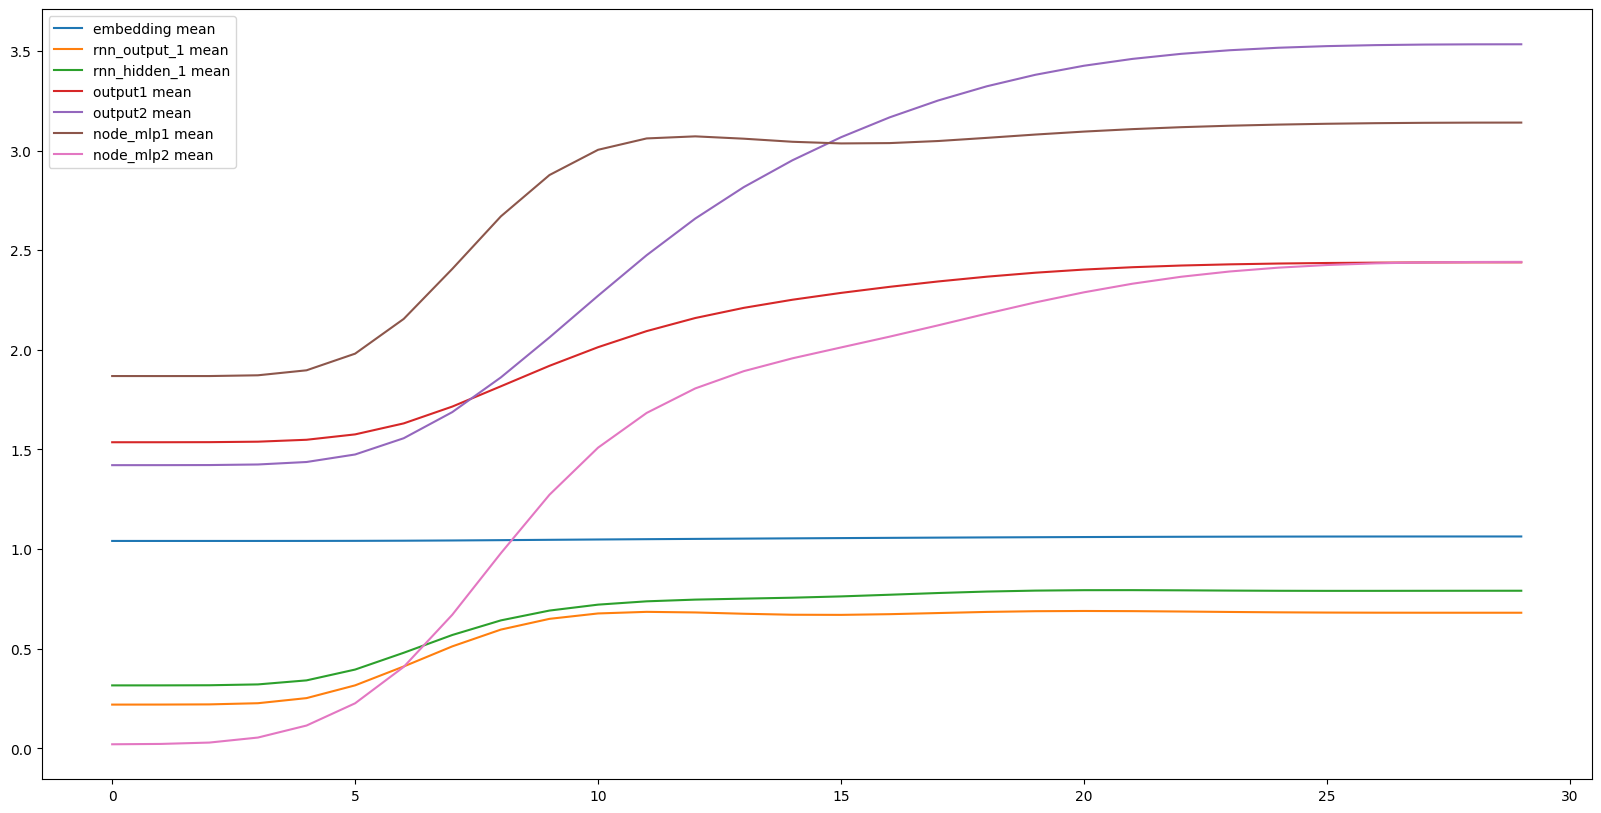

In [9]:
plt.figure(figsize=(20,10))
for color, k in enumerate(layer_hists_rnn.keys()):
    plt.plot([i for i in range(len(layer_stds_rnn[k]))], layer_stds_rnn[k], label=f'{k} mean'.format(i=color))
plt.legend(loc='best')

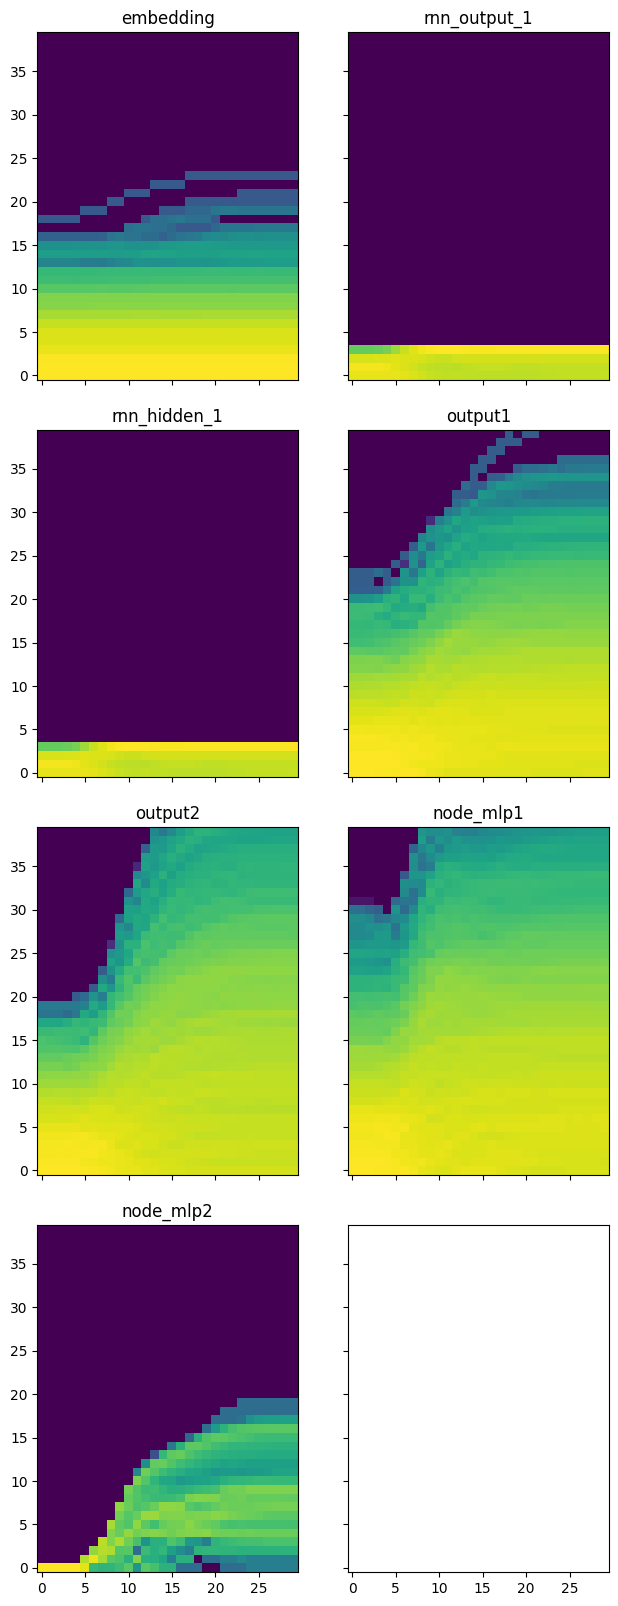

In [10]:
from mpl_toolkits.axes_grid1 import ImageGrid

def get_hist(h): return torch.stack(h).t().float().log1p() # with log you can see the range more clearly

# plt.figure(figsize=(20,10))

fig = plt.figure(figsize=(20., 20.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 2),  # creates 2x2 grid of axes
                 axes_pad=0.5,  # pad between axes in inch.
                )

for ax, k in zip(grid, list(layer_hists_rnn.keys())):
    # Iterating over the grid returns the Axes.
    im = get_hist(layer_hists_rnn[k])
    ax.imshow(im,  origin="lower",)
    ax.set_title(k)

plt.show()

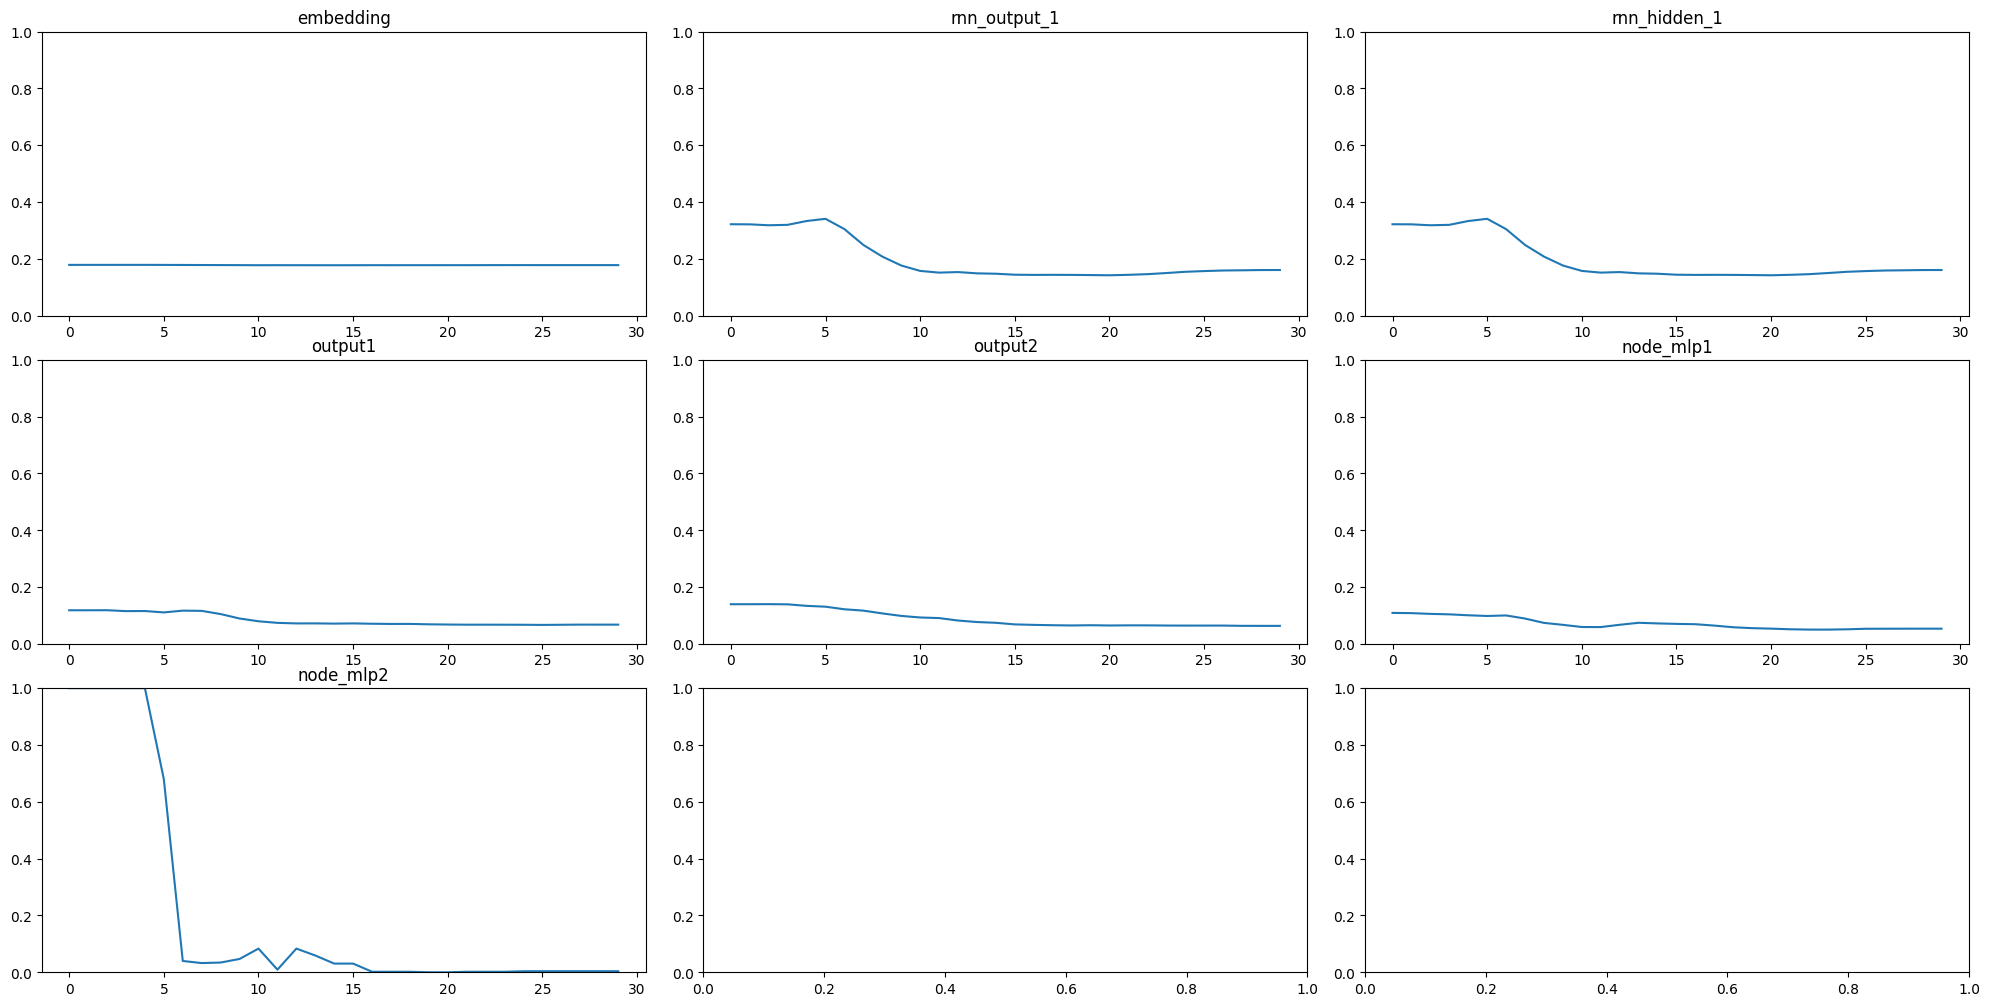

In [11]:
def get_min(h):
    h1 = torch.stack(h).t().float()
    return h1[0]/h1.sum(0)

fig, axes = plt.subplots(3,3, figsize=(20, 10))
fig.tight_layout()
for ax, k in zip(axes.flatten(), list(layer_hists_rnn.keys())):
    h = layer_hists_rnn[k]
    ax.plot(get_min(h))
    ax.set_title(k)
    ax.set_ylim(0,1)

In [12]:
print_obj_API(rnn)

GRU_plain Attributes: ['T_destination', 'call_super_init', 'dump_patches', 'hidden', 'hidden_size', 'node_lvl', 'num_layers', 'training']


GRU_plain Methods: ['ad_hoc_init', 'add_module', 'apply', 'bfloat16', 'buffers', 'children', 'cpu', 'cuda', 'double', 'embedding', 'eval', 'extra_repr', 'float', 'forward', 'get_buffer', 'get_extra_state', 'get_parameter', 'get_save_path', 'get_submodule', 'half', 'init_hidden', 'init_hidden_rand', 'ipu', 'load_state_dict', 'modules', 'named_buffers', 'named_children', 'named_modules', 'named_parameters', 'node_mlp1', 'node_mlp2', 'output1', 'output2', 'parameters', 'register_backward_hook', 'register_buffer', 'register_forward_hook', 'register_forward_pre_hook', 'register_full_backward_hook', 'register_full_backward_pre_hook', 'register_load_state_dict_post_hook', 'register_module', 'register_parameter', 'register_state_dict_pre_hook', 'requires_grad_', 'rnn', 'save', 'set_extra_state', 'share_memory', 'state_dict', 'to', 'to_empty', 'train', 'typ

# GRADIENTS

In [13]:
rnn, output = get_generator()
rnn.apply(weight_init)
output.apply(weight_init)
rnn.ad_hoc_init()
output.ad_hoc_init()

train_dataset_loader, val_dataset_loader = create_train_val_dataloaders(train_data, train_data, max_num_node, max_prev_node, bs) #! HERE WORKERS
params = list(rnn.parameters()) + list(output.parameters())
optimizer = torch.optim.RMSprop(params, lr=LRrnn)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LRrnn, steps_per_epoch=len(train_dataset_loader), epochs=max_epoch)


In [14]:
grads_dict = {}
for name, module in rnn.named_modules():
    for pname, p in module.named_parameters():
        if ".weight" in pname:
            grads_dict[pname] = []

def get_grads():
    for name, module in rnn.named_modules():
        for pname, p in module.named_parameters():
            if ".weight" in pname:
                grads_dict[pname].append(p.grad.data)



In [15]:
epoch = 0
while epoch < max_epoch:
    rnn.train()
    output.train()
    loss_all, loss_sum_edges, loss_sum_nodes = 0, 0, 0
    for batch_idx, data in enumerate(train_dataset_loader):
        rnn.zero_grad()
        output.zero_grad()
        loss, edge_loss, node_loss = fit_batch(data, rnn, output, node_weights, edge_weights)
        loss.backward()
        get_grads()
        optimizer.step()        
        if scheduler != None: scheduler.step()
        loss_sum_edges += edge_loss.data
        loss_sum_nodes += node_loss.data
        loss_all =  loss_sum_edges + loss_sum_nodes
        print(f"Epoch {epoch}, ", loss / (batch_idx + 1), 'lossedges', loss_sum_edges / (batch_idx + 1), ' lossnodes ',loss_sum_nodes / (batch_idx + 1))
    epoch +=1


Epoch 0,  tensor(0.8452, device='cuda:0', grad_fn=<DivBackward0>) lossedges tensor(0.5557, device='cuda:0')  lossnodes  tensor(0.2894, device='cuda:0')
Epoch 1,  tensor(0.8437, device='cuda:0', grad_fn=<DivBackward0>) lossedges tensor(0.5545, device='cuda:0')  lossnodes  tensor(0.2892, device='cuda:0')
Epoch 2,  tensor(0.8390, device='cuda:0', grad_fn=<DivBackward0>) lossedges tensor(0.5507, device='cuda:0')  lossnodes  tensor(0.2883, device='cuda:0')
Epoch 3,  tensor(0.8249, device='cuda:0', grad_fn=<DivBackward0>) lossedges tensor(0.5392, device='cuda:0')  lossnodes  tensor(0.2857, device='cuda:0')
Epoch 4,  tensor(0.7949, device='cuda:0', grad_fn=<DivBackward0>) lossedges tensor(0.5147, device='cuda:0')  lossnodes  tensor(0.2803, device='cuda:0')
Epoch 5,  tensor(0.7447, device='cuda:0', grad_fn=<DivBackward0>) lossedges tensor(0.4729, device='cuda:0')  lossnodes  tensor(0.2718, device='cuda:0')


Epoch 6,  tensor(0.6713, device='cuda:0', grad_fn=<DivBackward0>) lossedges tensor(0.4105, device='cuda:0')  lossnodes  tensor(0.2608, device='cuda:0')
Epoch 7,  tensor(0.5761, device='cuda:0', grad_fn=<DivBackward0>) lossedges tensor(0.3256, device='cuda:0')  lossnodes  tensor(0.2505, device='cuda:0')
Epoch 8,  tensor(0.4714, device='cuda:0', grad_fn=<DivBackward0>) lossedges tensor(0.2272, device='cuda:0')  lossnodes  tensor(0.2443, device='cuda:0')
Epoch 9,  tensor(0.3798, device='cuda:0', grad_fn=<DivBackward0>) lossedges tensor(0.1378, device='cuda:0')  lossnodes  tensor(0.2420, device='cuda:0')
Epoch 10,  tensor(0.3158, device='cuda:0', grad_fn=<DivBackward0>) lossedges tensor(0.0751, device='cuda:0')  lossnodes  tensor(0.2407, device='cuda:0')
Epoch 11,  tensor(0.2772, device='cuda:0', grad_fn=<DivBackward0>) lossedges tensor(0.0388, device='cuda:0')  lossnodes  tensor(0.2384, device='cuda:0')
Epoch 12,  tensor(0.2552, device='cuda:0', grad_fn=<DivBackward0>) lossedges tensor(0.

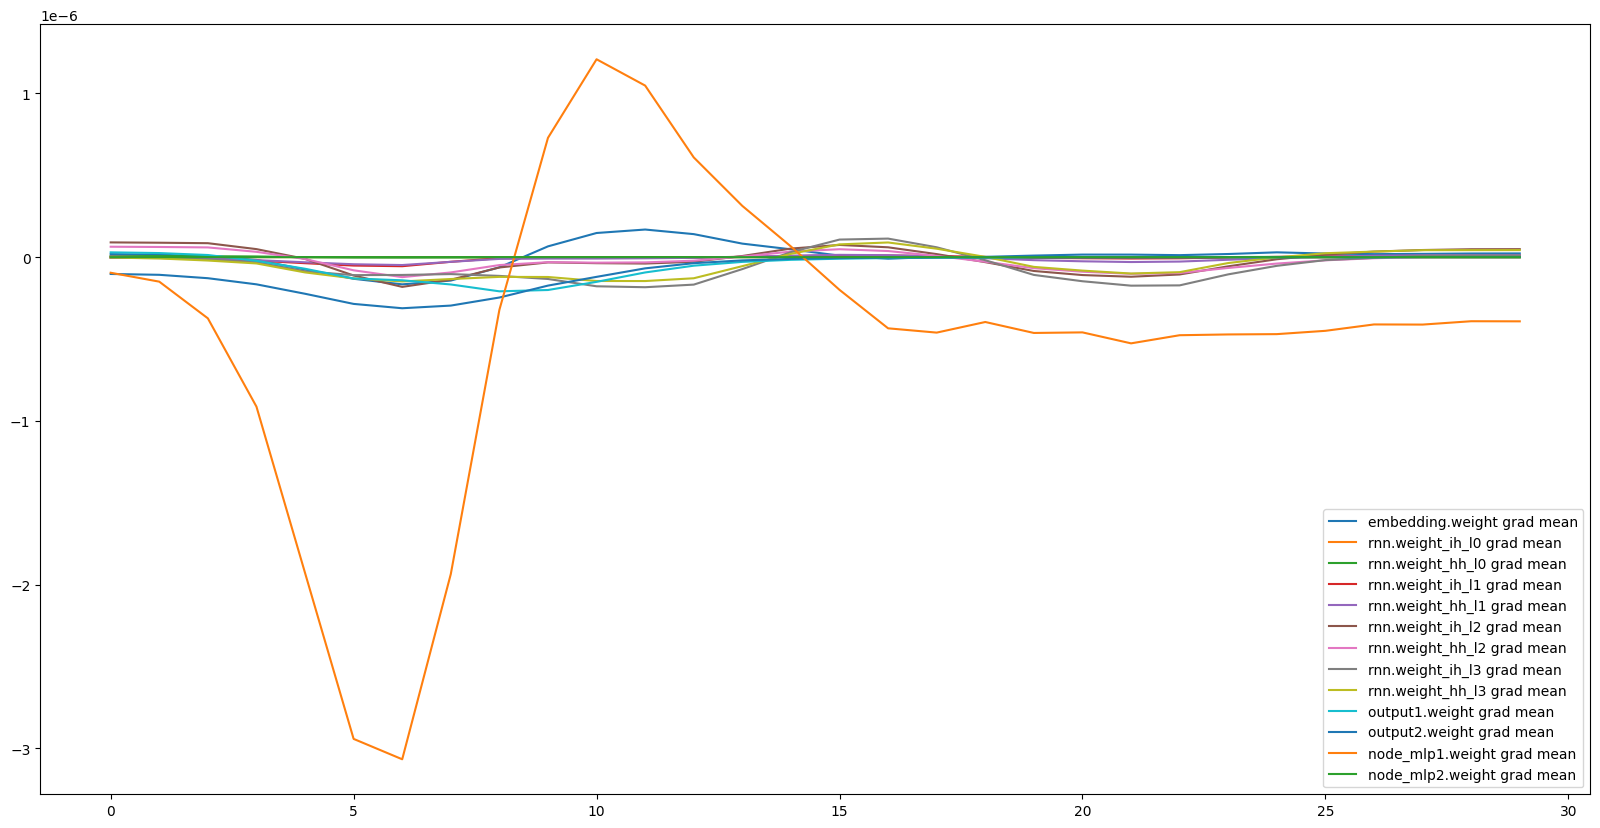

In [16]:
plt.figure(figsize=(20,10))

for k in grads_dict.keys():
    l = grads_dict[k]
    r = range(len(l))
    plt.plot([i for i in r], [l[step].data.mean().cpu() for step in r], label=f'{k} grad mean'.format(i=color))
plt.legend(loc='best')

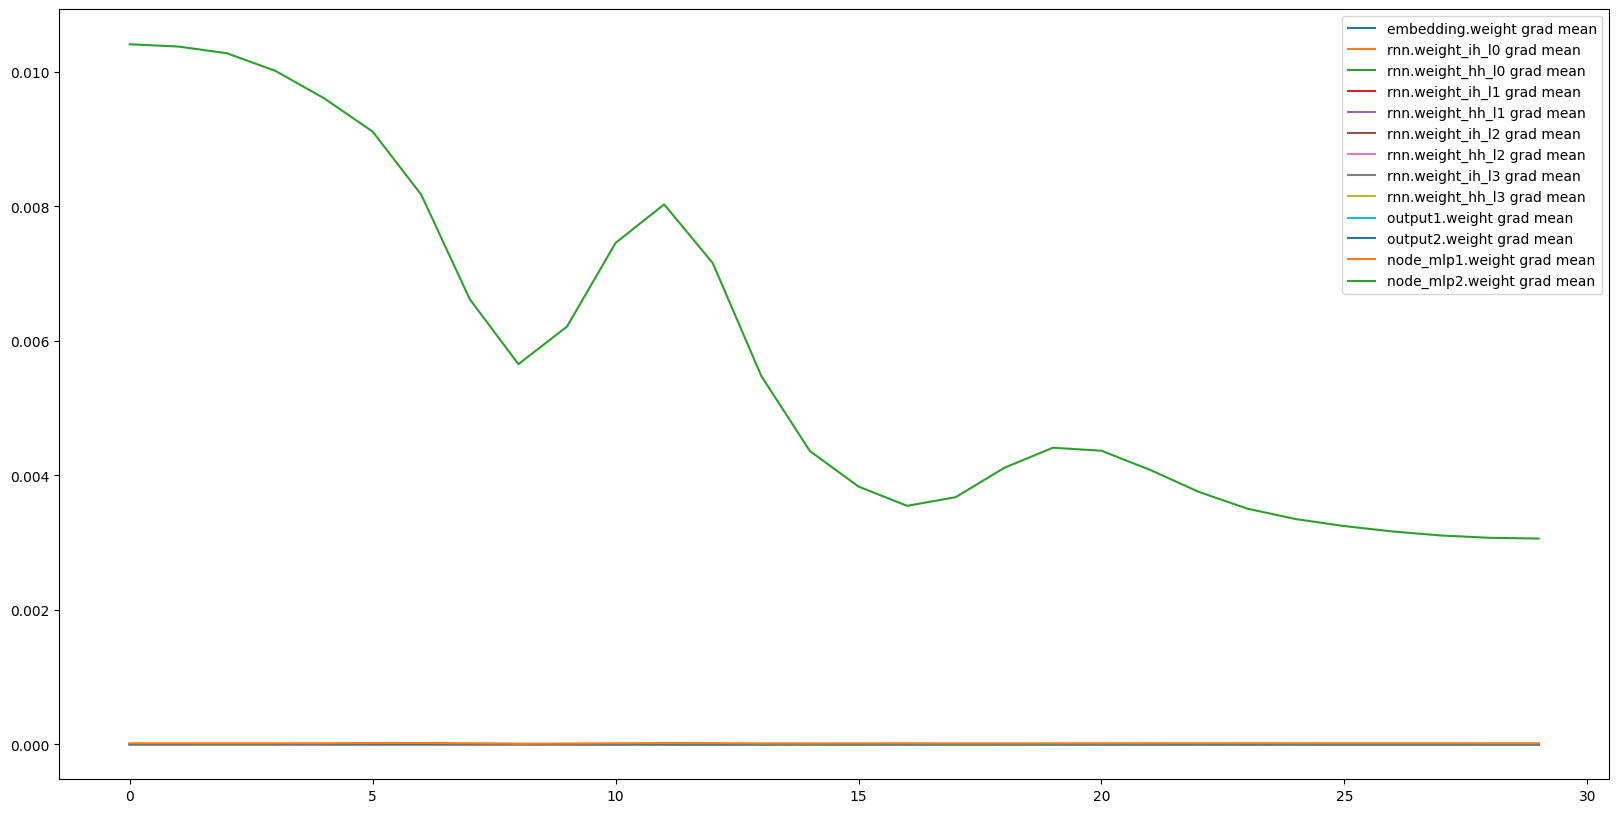

In [17]:
plt.figure(figsize=(20,10))

for k in grads_dict.keys():
    l = grads_dict[k]
    r = range(len(l))
    plt.plot([i for i in r], [l[step].data.std().cpu() for step in r], label=f'{k} grad mean'.format(i=color))
plt.legend(loc='best')